<a href="https://colab.research.google.com/github/anntranhuu/CBA_Automation/blob/main/CBA_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cost Benefit Automation Project

## Objectives

The aim of this project is to get a better idea of how Python (together with SQL) can be used to automate the Cost-Benefit Analysis (CBA) process.

## Contents

Below is the structure of the project:
1. Create Mock Database using SQL
2. Create a Function for CBA
3. Create Function to Plot Results
4. Apply Functions to Mock Database
5. Interpretation

First a mock database will be created representing data from one particular project (e.g. Hybrid Offshore Assets).

## Create a Mock Database using SQL

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create a database
conn = sqlite3.connect("project_data.db")
cur = conn.cursor()

# Create table
cur.execute("""
CREATE TABLE project_cba (
    year INTEGER,
    capex REAL,
    opex REAL,
    benefit_energy REAL,
    benefit_co2 REAL,
    discount_rate REAL
)
""")



The above columns in the table are based on some of the features that are expected to be found in data to be used for CBA in line with OFGEM and ENTSOE methodologies. Definitions of each of the features are as follows:

- **Year**: The year the data applies to
- **Capex**: Capital Expenditure, i.e. how much is expected to build the infrastructure
- **Opex**: Operational Expenditure, i.e. how much is expected to operate and maintain the project
- **Benefit_energy**: How much cheaper (or more efficient) is the energy compared to alternatives?
- **Benefit_co2**: The monetised value of carbon emissions avoided by using cleaner energy sources instead of dirtier ones
- **Discount_rate**: Discount rate set by regulators to be used to calculate the discount factor and thus NPV (Net Present Value). This is needed as the money today is worth more than in the future due to factors like inflation and lost money from investing.


In [3]:
# Insert example data
cur.executemany("""
INSERT INTO project_cba (year, capex, opex, benefit_energy, benefit_co2, discount_rate)
VALUES (?, ?, ?, ?, ?, ?)
""", [
    (2024, 5_000_000, 250_000, 0, 0, 0.035),
    (2025, 1_000_000, 50_000, 300_000, 20_000, 0.035),
    (2026, 2_000_000, 50_000, 310_000, 21_000, 0.035),
    (2027, 1_200_000, 50_000, 320_000, 22_000, 0.035),
    (2028, 3_000_000, 330_000, 890_000, 135_000, 0.035)
])

df = pd.read_sql_query("SELECT * FROM project_cba", conn)

conn.commit()
conn.close()


In [4]:
df

,year,capex,opex,benefit_energy,benefit_co2,discount_rate
0,2024,5000000.0,250000.0,0.0,0.0,0.035
1,2025,1000000.0,50000.0,300000.0,20000.0,0.035
2,2026,2000000.0,50000.0,310000.0,21000.0,0.035
3,2027,1200000.0,50000.0,320000.0,22000.0,0.035
4,2028,3000000.0,330000.0,890000.0,135000.0,0.035


## Create a Function for CBA

In [5]:
# Step 3: Calculate CBA
def calculate_cba(df):
    min_year = df['year'].min()
    df['discount_factor'] = 1 / (1 + df['discount_rate']) ** (df['year'] - min_year)

    df['discounted_capex'] = df['capex'] * df['discount_factor']
    df['discounted_opex'] = df['opex'] * df['discount_factor']
    df['discounted_benefit_energy'] = df['benefit_energy'] * df['discount_factor']
    df['discounted_benefit_co2'] = df['benefit_co2'] * df['discount_factor']

    df['total_discounted_benefits'] = df['discounted_benefit_energy'] + df['discounted_benefit_co2']
    df['total_discounted_costs'] = df['discounted_capex'] + df['discounted_opex']

    npv = df['total_discounted_benefits'].sum() - df['total_discounted_costs'].sum()
    bcr = df['total_discounted_benefits'].sum() / df['total_discounted_costs'].sum()

    return df, round(npv, 2), round(bcr, 2)

In [6]:
## Apply function to dataframe
calculate_cba(df)

(   year      capex      opex  benefit_energy  benefit_co2  discount_rate  \
 0  2024  5000000.0  250000.0             0.0          0.0          0.035   
 1  2025  1000000.0   50000.0        300000.0      20000.0          0.035   
 2  2026  2000000.0   50000.0        310000.0      21000.0          0.035   
 3  2027  1200000.0   50000.0        320000.0      22000.0          0.035   
 4  2028  3000000.0  330000.0        890000.0     135000.0          0.035   
 
    discount_factor  discounted_capex  discounted_opex  \
 0         1.000000      5.000000e+06    250000.000000   
 1         0.966184      9.661836e+05     48309.178744   
 2         0.933511      1.867021e+06     46675.535018   
 3         0.901943      1.082331e+06     45097.135283   
 4         0.871442      2.614327e+06    287575.935141   
 
    discounted_benefit_energy  discounted_benefit_co2  \
 0                   0.000000                0.000000   
 1              289855.072464            19323.671498   
 2             

## Create Function to Plot Results

In [9]:
# Step 4: Create a Function to Plot results
def plot_results(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['year'], df['total_discounted_benefits'], label='Discounted Benefits', color='green')
    plt.plot(df['year'], df['total_discounted_costs'], label='Discounted Costs', color='red')
    plt.title('CBA: Discounted Benefits vs Costs')
    plt.xlabel('Year')
    plt.ylabel('Amount (£)')
    plt.legend()
    plt.grid(True)
    plt.show()


## Apply Functions to Mock Database

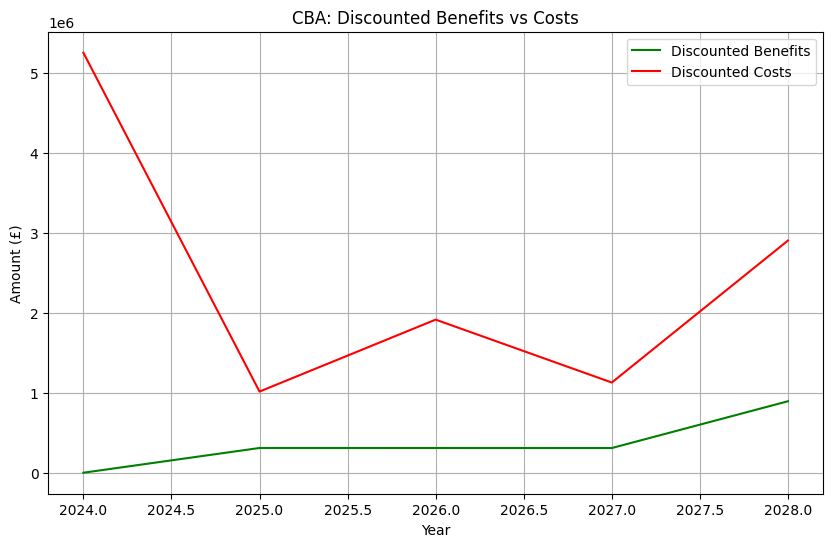


Net Present Value (NPV): £-10,387,657.22
Benefit-Cost Ratio (BCR): 0.15


In [10]:
# Run the whole process
df_result, npv, bcr = calculate_cba(df)
plot_results(df_result)

print(f"\nNet Present Value (NPV): £{npv:,.2f}")
print(f"Benefit-Cost Ratio (BCR): {bcr:.2f}")

## Interpretation

A positive NPV means that the project will be protitable, as the expected earnings exceed the anticipated costs (also in today's currency valuation). However, as the NPV for this mock data is negative (-£10,387,657.22), it means that the project does not add value, and will in fact result in a loss of around 10 million pounds in today's valuation.

A BCR that is greater than 1 means that the benefits outweigh the costs. The value we achieved for the BCR was 0.15, so as this is smaller than 1, it means that the benefits do not outweigh the costs.